In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import sklearn
import matplotlib


In [2]:
matplotlib.rcParams.update({
    'font.size':18,
    'legend.fontsize':20,
    'axes.labelsize':14,
    'figure.titlesize':22,
    'lines.linewidth': 2.5,
    'lines.markersize': 12.0
})
#matplotlib.rcParams

In [3]:
dates = np.array([  '2020-03-08',
                    '2020-03-09',
                    '2020-03-10',
                    '2020-03-11',
                    '2020-03-12',
                    '2020-03-13',
                    '2020-03-14',
                    '2020-03-15',
                    '2020-03-16',
                    '2020-03-17',
                    '2020-03-18',
                    '2020-03-19',
                    '2020-03-20',
                    '2020-03-21',
                    '2020-03-22',
                    '2020-03-23'], dtype='datetime64')

total_cases = np.array([0,2,2,6,10,21,26,33,46,49,58,67,75,84,95,116], dtype='intc')
##new cases each day

from_hospitals = np.array([0,
                           0,#  09/3/2020 
                           0,
                           0,
                           0,
                           0,
                           0,
                           0,
                           11, # 16/3/2020
                           0,
                           0,
                           0,
                           3,
                           1,
                           4,
                           3 #23/3/20
                          ], 
                          dtype='intc') #includes medical personel working there

days_from_onset = np.array([i for i in range(-1, len(dates)-1)])

from_travel = np.array([ 0,
                        2,#  09/3/2020 
                        0,
                        2,
                        4,
                        4,
                        2,
                        5,
                        2, # 16/3/2020
                        1,
                        3,
                        3,
                        0,
                        5,
                        4,
                        6   #23/3/20
                       ],
                      dtype='intc')


#not accounted from the above
new_cases = np.array([0, #  09/3/2020
                      0,
                      0,
                      2,
                      0,
                      7,
                      3,
                      2,
                      0, # 16/3/2020
                      2,
                      6,
                      6,
                      5,
                      3,
                      3,
                      12 #23/3/20
                     ],
                     dtype='intc')


##from quarantine includes people that were put in guarantin due to close contacts with known cases
dates_of_preventive_measures = np.array(['2020-03-14'], dtype='datetime64')

# MEASURES TAKEN

# 14-3-2020 Cafes, restaurants, pubs etc close 

In [4]:
daily_diff = np.insert(np.diff(total_cases),0,total_cases[0],axis=0)
print(daily_diff.tolist())
seperate_daily_diff = np.sum([from_hospitals, from_travel, new_cases], dtype='intc', axis=0)
print(seperate_daily_diff.tolist())
if(np.sum(np.diff([daily_diff,seperate_daily_diff],axis=0)) != 0):
    print("Error: seperate new cases and total new cases do not match")

[0, 2, 0, 4, 4, 11, 5, 7, 13, 3, 9, 9, 8, 9, 11, 21]
[0, 2, 0, 4, 4, 11, 5, 7, 13, 3, 9, 9, 8, 9, 11, 21]


## Total Cases

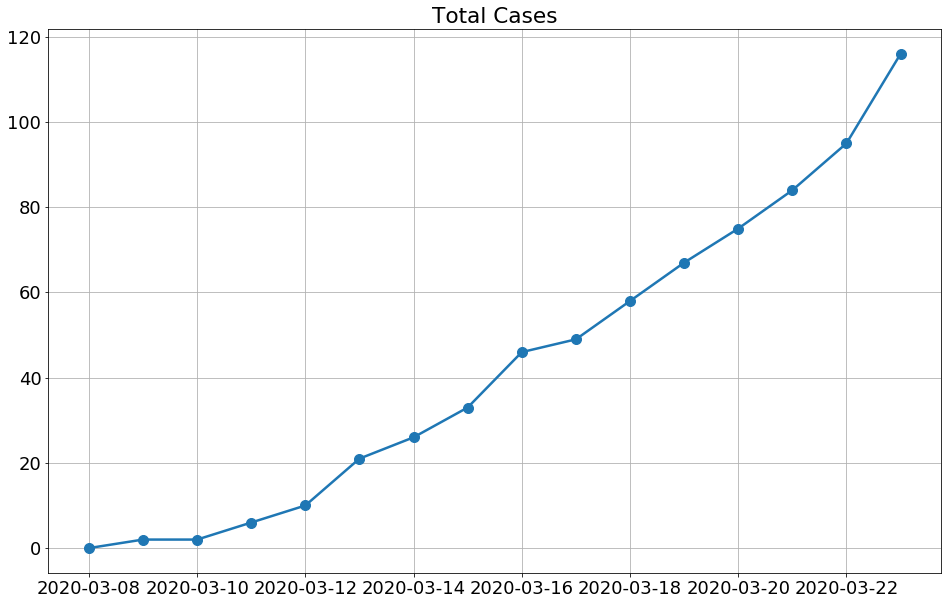

In [5]:
fig = plt.figure(figsize=(16,10))
plt.plot(dates, total_cases, marker="o", markersize=10, linewidth=2.5)
plt.title('Total Cases')
plt.grid(True)

R2 score: 0.9644888644997519


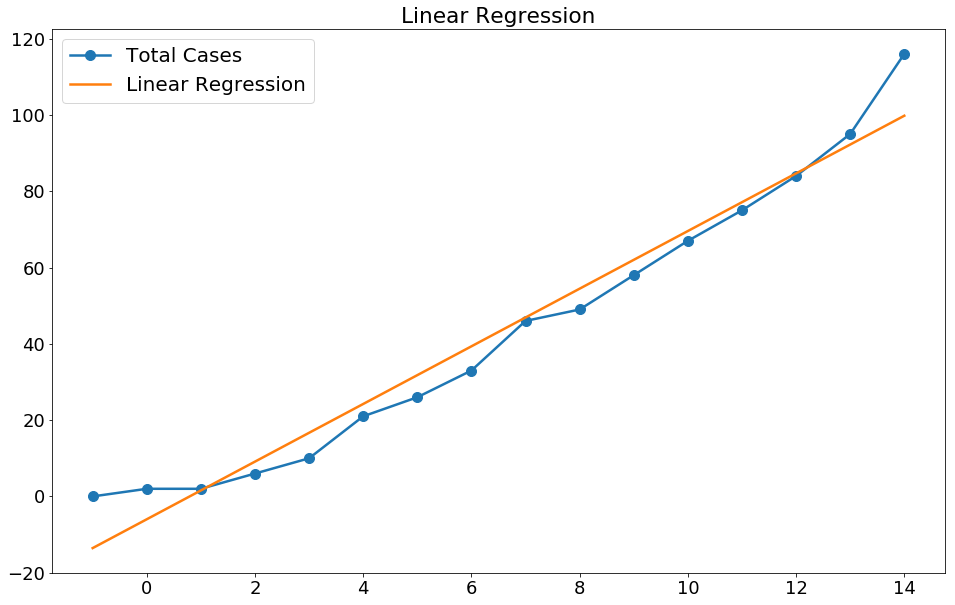

In [6]:
fig = plt.figure(figsize=(16,10))

plt.plot(days_from_onset, total_cases, marker="o", markersize=10, linewidth=2.5, label='Total Cases')

linearReg = LinearRegression().fit(days_from_onset.reshape(-1, 1), total_cases.reshape(-1,1))
#print(linearReg.coef_)
print('R2 score: ' + str(linearReg.score(days_from_onset.reshape(-1,1),total_cases.reshape(-1,1))))

pred = linearReg.predict(days_from_onset.reshape(-1,1))
plt.plot(days_from_onset,pred, linewidth=2.5, label='Linear Regression')
plt.title('Linear Regression')
plt.legend(loc='upper left')

In [7]:
print('Prediction for tomorrow using Linear fit: ' + str(linearReg.predict(days_from_onset[-1]+1)))

Prediction for tomorrow using Linear fit: [[107.35]]


R2 score: 0.963450076229255


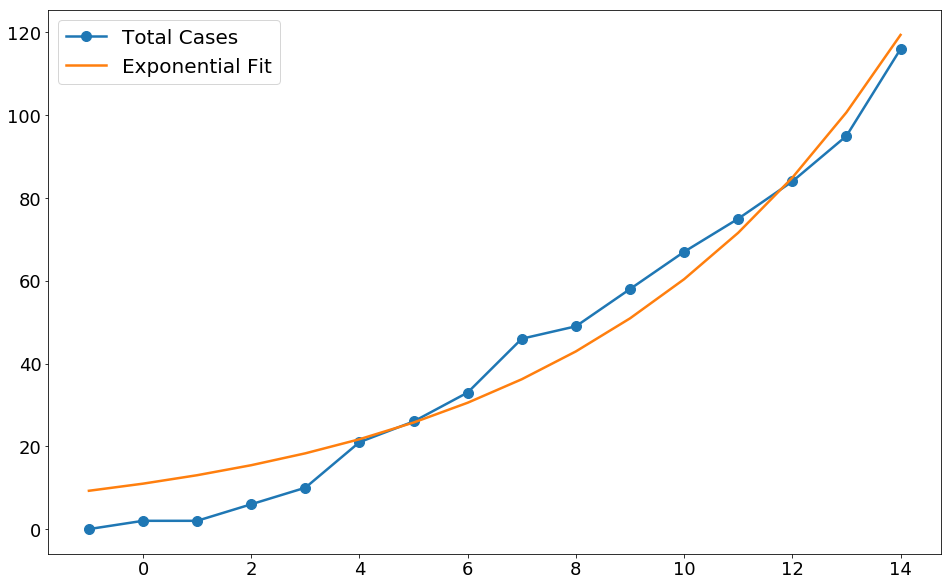

In [8]:
fig = plt.figure(figsize=(16,10))

plt.plot(days_from_onset, total_cases, marker="o", markersize=10, linewidth=2.5, label='Total Cases')

ret = scipy.optimize.curve_fit(lambda t,a,b:a*np.exp(b*t), days_from_onset,total_cases, p0 = [0.5,0])
regC = ret[0]
#print(regC)
a = regC[0]
b = regC[1]
prediction = a*np.exp(b*days_from_onset)
print("R2 score: " + str(sklearn.metrics.r2_score(total_cases, prediction)))

pred = linearReg.predict(days_from_onset.reshape(-1,1))
plt.plot(days_from_onset,prediction, linewidth=2.5, label='Exponential Fit')
plt.legend(loc='upper left')

In [9]:
print('Prediction for tomorrow using exponential fit: ' + str(a*np.exp(b*(days_from_onset[-1]+1))))

Prediction for tomorrow using exponential fit: 141.60943519482734


In [10]:
scipy.optimize.curve_fit(lambda t,b,c:np.exp(b*t)+c, days_from_onset,total_cases)

(array([ 0.33631569, 18.9728898 ]), array([[ 7.53325452e-05, -2.10557668e-02],
        [-2.10557668e-02,  2.01001371e+01]]))

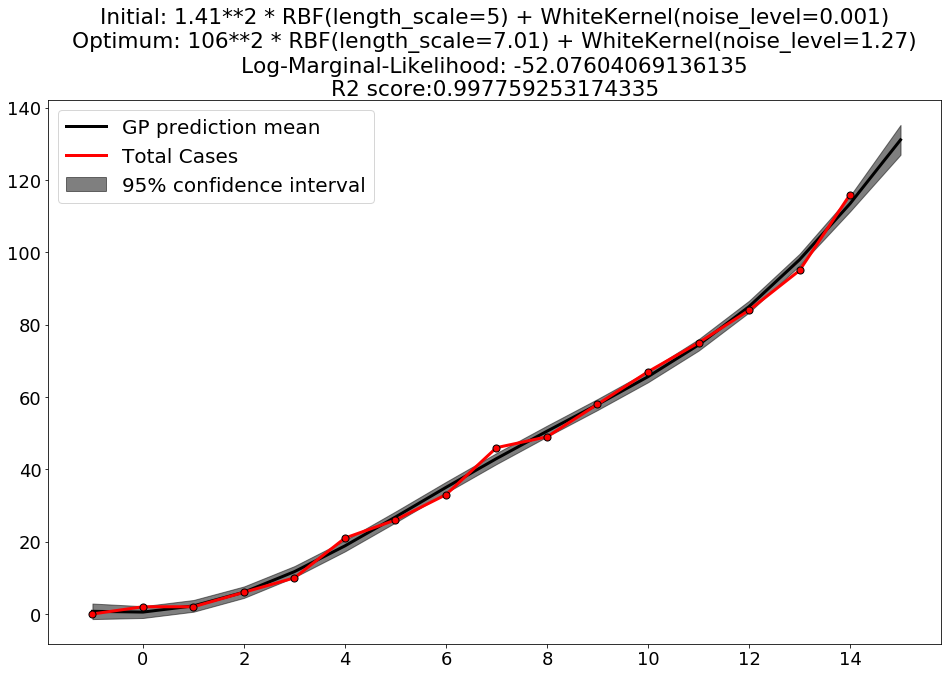

In [11]:
fig = plt.figure(figsize=(16,10))

kernel = 2.0 * RBF(length_scale=5, length_scale_bounds=(1e-4, 1e6)) \
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=3).fit(days_from_onset.reshape(-1,1), total_cases)

X_ = np.append(days_from_onset, [days_from_onset[-1]+1]).reshape(-1,1)
y_mean, y_cov = gp.predict(X_, return_cov=True)

plt.plot(X_, y_mean, 'k', lw=3, zorder=9, label='GP prediction mean')
plt.fill_between(X_.flatten(), y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k', label='95% confidence interval')
plt.plot(days_from_onset, total_cases, 'r', lw=3, zorder=9, label='Total Cases')
plt.scatter(days_from_onset, total_cases, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s\nR2 score:%s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta), gp.score(days_from_onset.reshape(-1,1),total_cases)))
plt.legend(loc='upper left')

In [12]:
print('Tomorrow\'s prediction using GP model: ' + str(y_mean[-1]))
print('95% Confidence interval: [' + str(y_mean[-1]-np.sqrt(np.diag(y_cov)[-1])) + ',' 
      + str(y_mean[-1]+np.sqrt(np.diag(y_cov)[-1])) + ']' )

Tomorrow's prediction using GP model: 131.1405132852833
95% Confidence interval: [127.0165173116788,135.2645092588878]


## New Cases Breakdown

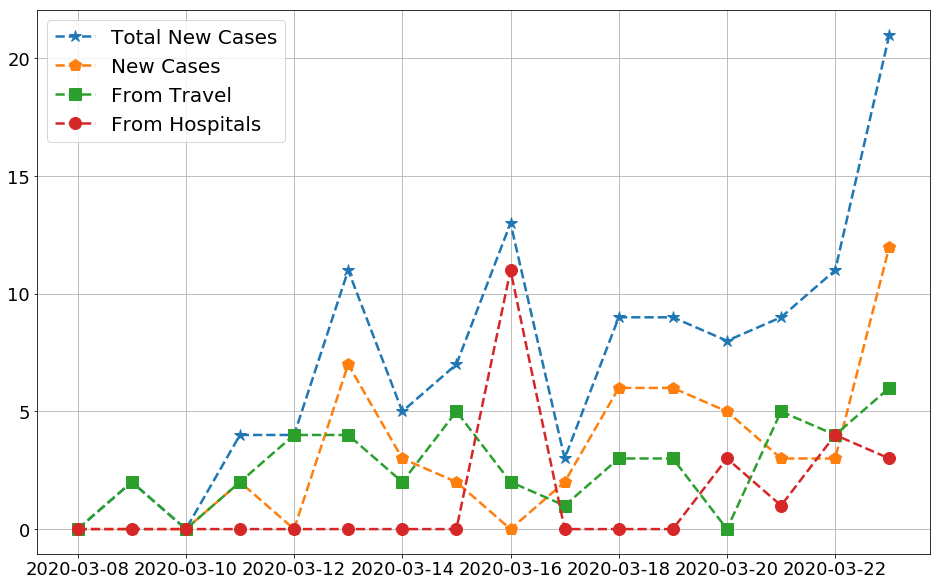

In [13]:
fig = plt.figure(figsize=(16,10))
total_daily_new_cases = np.diff(total_cases)
plt.plot(dates, np.insert(total_daily_new_cases,0,[0]), '*--',  label='Total New Cases')
plt.plot(dates, new_cases, 'p--', label='New Cases')
plt.plot(dates, from_travel, 's--', label='From Travel')
plt.plot(dates, from_hospitals, 'o--', label='From Hospitals')
plt.legend(loc='upper left')
plt.grid(True, 'major')

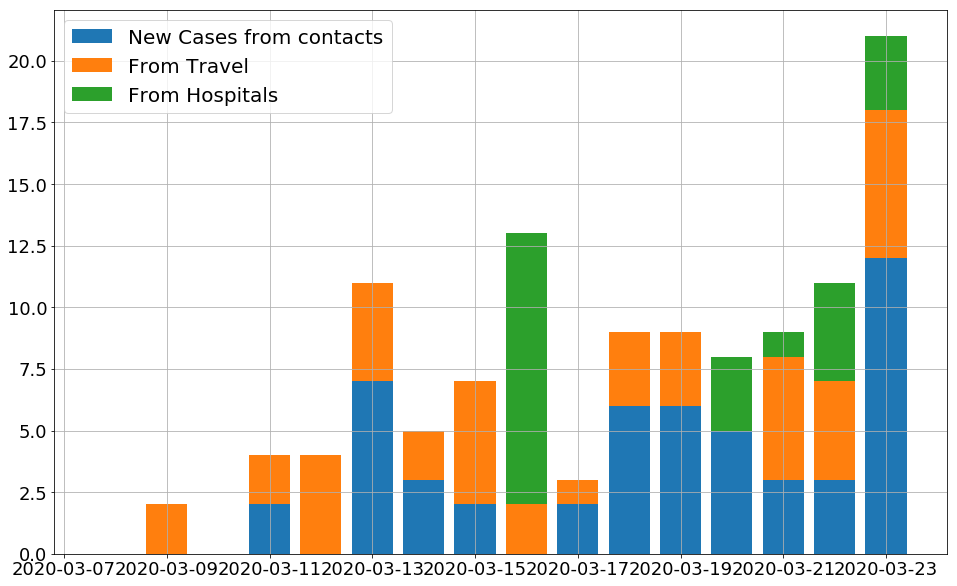

In [14]:
fig = plt.figure(figsize=(16,10))
plt.bar(dates, new_cases, label='New Cases from contacts')
plt.bar(dates, from_travel, bottom=new_cases, label='From Travel')
plt.bar(dates, from_hospitals,bottom=from_travel+new_cases, label='From Hospitals')
plt.legend(loc='upper left')
plt.grid(True, 'major')

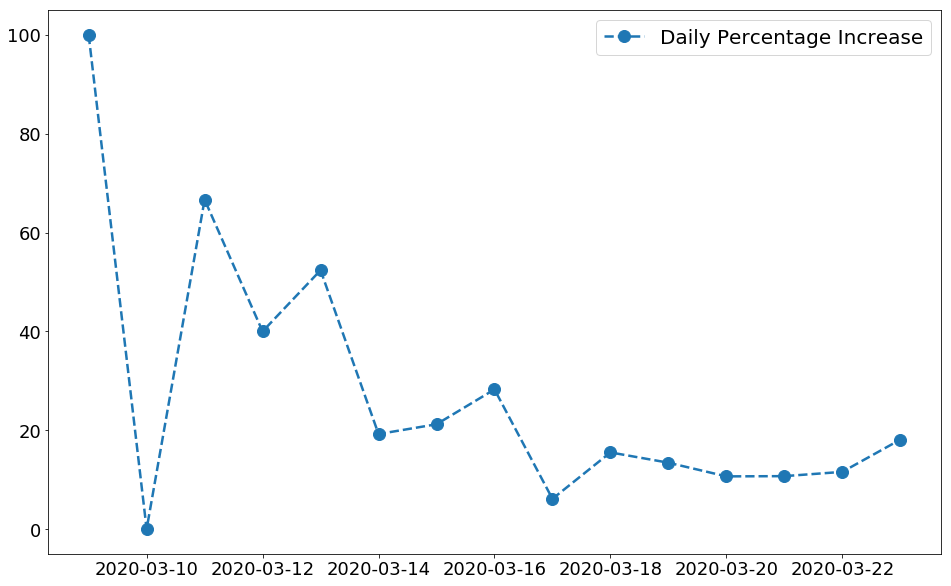

In [15]:
fig = plt.figure(figsize=(16,10))

percentage_increase = np.diff(total_cases) / total_cases[1:] * 100
plt.plot(dates[1:], percentage_increase, 'o--', markersize=12, linewidth=2.5, label='Daily Percentage Increase')
plt.legend(loc='upper right')

[2.98598505 0.11746641]
R2 score: -0.8092456963774619


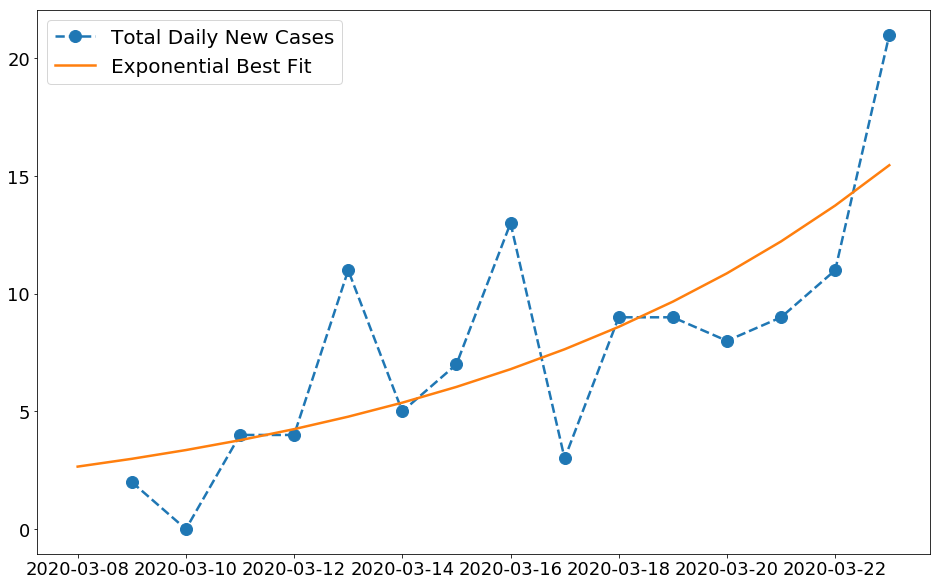

In [16]:
fig = plt.figure(figsize=(16,10))

plt.plot(dates[1:],np.diff(total_cases), 'o--', markersize=12, linewidth=2.5, label='Total Daily New Cases')

ret = scipy.optimize.curve_fit(lambda t,a,b:a*np.exp(b*t), days_from_onset[1:],np.diff(total_cases), p0 = [0.5,0])
regC = ret[0]
print(regC)
a = regC[0]
b = regC[1]
prediction = a*np.exp(b*days_from_onset)
print("R2 score: " + str(sklearn.metrics.r2_score(total_cases, prediction)))

pred = linearReg.predict(days_from_onset.reshape(-1,1))
plt.plot(dates,prediction, linewidth=2.5, label='Exponential Best Fit')


plt.legend(loc='upper left')

In [17]:
print('Prediction for new cases tomorrow using exponential fit: ' + str(a*np.exp(b*(days_from_onset[-1]+1))))

Prediction for new cases tomorrow using exponential fit: 17.3905315403405


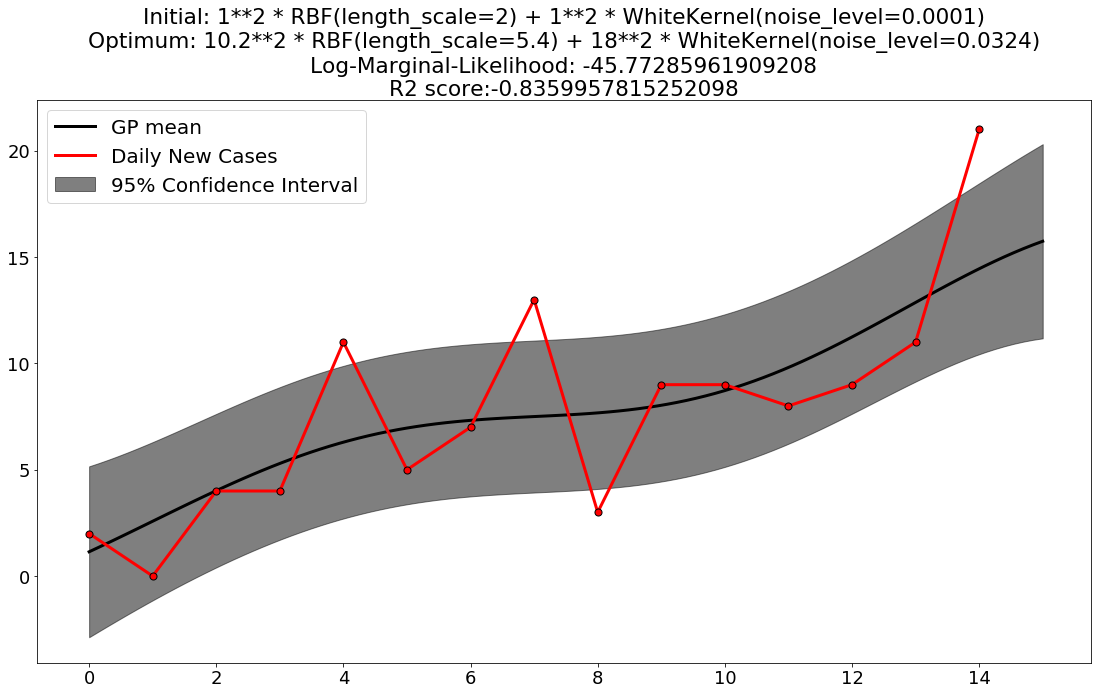

In [18]:
kernel = 1.0 * RBF(length_scale=2, length_scale_bounds=(2,7)) \
        + 1.0 * WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-10, 1e2))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=2).fit(days_from_onset[1:].reshape(-1,1), np.diff(total_cases))

X_ = np.linspace(days_from_onset[1], [days_from_onset[-1]+1],num=100)
y_mean, y_cov = gp.predict(X_.reshape(-1,1), return_cov=True)

fig = plt.figure(figsize=(16,10))
plt.plot(X_.flatten(), y_mean, 'k', lw=3, zorder=9, label='GP mean')
plt.fill_between(X_.flatten(), y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k', label='95% Confidence Interval')
plt.plot(days_from_onset[1:], np.diff(total_cases), 'r', lw=3, zorder=9, label='Daily New Cases')
plt.scatter(days_from_onset[1:], np.diff(total_cases), c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s\nR2 score:%s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta), gp.score(days_from_onset.reshape(-1,1),total_cases)))
plt.tight_layout()
plt.legend(loc='upper left')

In [19]:
print(len(X_.flatten()))
print(len(y_mean))

print(X_.flatten()[:10])
print(y_mean[:10])

100
100
[0.         0.15151515 0.3030303  0.45454545 0.60606061 0.75757576
 0.90909091 1.06060606 1.21212121 1.36363636]
[1.1415023  1.35288154 1.56732051 1.78430562 2.0033072  2.22378204
 2.44517603 2.66692695 2.88846734 3.10922753]


In [20]:
print('Tomorrow\'s prediction using GP model: ' + str(y_mean[-1]))
print('95% Confidence interval: [' + str(y_mean[-1]-np.sqrt(np.diag(y_cov)[-1])) + ',' 
      + str(y_mean[-1]+np.sqrt(np.diag(y_cov)[-1])) + ']' )

Tomorrow's prediction using GP model: 15.743968143454467
95% Confidence interval: [11.17964198083213,20.308294306076803]
